#PSET 1 for 9.S912 by Ariel Fuchs




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from google.colab import files
import seaborn as sns

# 1. Mount Google Drive in Google Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


## Upload and unpack zip file and check that it was moved to the right location

In [58]:
import zipfile

zip_file_path = '/content/archive.zip'
extract_path = '/content/drive/MyDrive/1MIT/9.S912'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [15]:
%cd "/content/drive/MyDrive/1MIT/9.S912/"
!ls
# !rm train -r

/content/drive/MyDrive/1MIT/9.S912
 flowers  'PSET 1.gslides'   PSET1.ipynb   test   train


# 2. Split the dataset into training and testing


In [17]:
import os
import shutil
from random import shuffle

def split_dataset(base_dir, output_dir, train_percentage):
    # # Ensure the output directory exists
    # if not os.path.exists(output_dir):
    #     os.makedirs(output_dir)

    train_dir = os.path.join(output_dir, "train")
    test_dir = os.path.join(output_dir, "test")

    # Loop through each flower type directory
    for flower_type in os.listdir(base_dir):
        flower_dir = os.path.join(base_dir, flower_type)

        # Ensure we're looking at a directory
        if os.path.isdir(flower_dir):
            images = [f for f in os.listdir(flower_dir) if os.path.isfile(os.path.join(flower_dir, f))]
            shuffle(images)

            # Split based on the given percentage
            train_count = int(len(images) * train_percentage)
            train_images = images[:train_count]
            test_images = images[train_count:]

            # Create directories for each flower type under train and test
            train_flower_dir = os.path.join(train_dir, flower_type)
            test_flower_dir = os.path.join(test_dir, flower_type)
            os.makedirs(train_flower_dir, exist_ok=True)
            os.makedirs(test_flower_dir, exist_ok=True)

            # Move the images to their respective directories
            for image in train_images:
                shutil.move(os.path.join(flower_dir, image), os.path.join(train_flower_dir, image))

            for image in test_images:
                shutil.move(os.path.join(flower_dir, image), os.path.join(test_flower_dir, image))

# Usage:
base_directory = "/content/drive/MyDrive/1MIT/9.S912/flowers"
output_directory = "/content/drive/MyDrive/1MIT/9.S912"
train_percentage = 0.8  # Use 80% of data for training
split_dataset(base_directory, output_directory, train_percentage)

In [3]:
%cd "/content/drive/MyDrive/1MIT/9.S912/test"
!ls
!ls daisy -1 | wc -l
!ls dandelion -1 | wc -l
!ls rose -1 | wc -l
!ls sunflower -1 | wc -l
!ls tulip -1 | wc -l


%cd "/content/drive/MyDrive/1MIT/9.S912/train"
!ls
!ls daisy -1 | wc -l
!ls dandelion -1 | wc -l
!ls rose -1 | wc -l
!ls sunflower -1 | wc -l
!ls tulip -1 | wc -l

/content/drive/MyDrive/1MIT/9.S912/test
daisy  dandelion  rose	sunflower  tulip
153
211
157
147
197
/content/drive/MyDrive/1MIT/9.S912/train
daisy  dandelion  rose	sunflower  tulip
611
841
627
586
787


**1. Modify ResNet50 to Return the 2048 Neuron Activations:**

To modify ResNet50 to return the activations, we remove the last fully
connected layer.

## 1. Loading the Dataset:
We'll use PyTorch's ImageFolder dataset class along with the transforms module to preprocess our data:



In [19]:
from IPython.testing import test
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_path = "/content/drive/MyDrive/1MIT/9.S912/train"
test_path = "/content/drive/MyDrive/1MIT/9.S912/test"

train_dataset = ImageFolder(train_path, transform=data_transforms['train'])
test_dataset = ImageFolder(test_path, transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [63]:
#This mapping helps with the visuals below
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
idx_to_class

{0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}

# 2. Loading the Pre-trained ResNet Model:

In [20]:
import torchvision.models as models

model = models.resnet50(pretrained=True)
print(model)

# Freeze all the layers except the final one
for param in model.parameters():
    param.requires_grad = False

# Replace the last layer to adjust to our classification task
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 5)  # 5 classes for 5 flower types


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 3. Fine-tuning the Model:

In [21]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 4. Training:

In [22]:
num_epochs = 1  # adjust as needed

for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}")

print("Training complete!")


Epoch 0/0, Loss: 0.7371
Training complete!


# 6. Extract Features, Use PCA to Reduce Dimensionality, Visualize the Reduced Data

In [12]:
for name, module in model.named_modules():
    print(name)

NameError: ignored

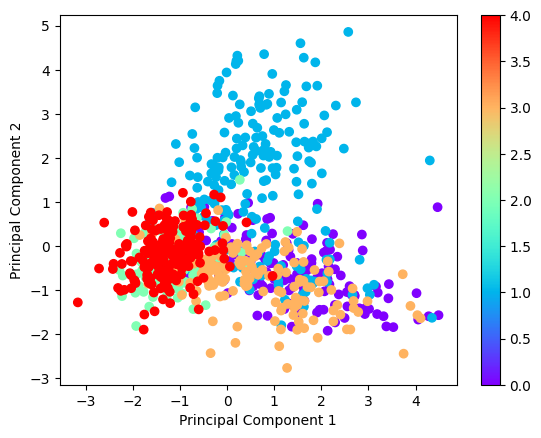

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming `model` is your trained PyTorch model and `dataloader` is your data loader for the dataset
# Extract features from an intermediate layer

def get_features_from_model(model, dataloader, layer_name):
    features_list = []
    labels_list = []

    # Switch model to evaluation mode
    model.eval()

    # Define a hook to get the activations from the desired layer
    def hook(module, input, output):
        features_list.append(output)

    hook_ref = dict()
    for name, layer in model.named_modules():
        if name == layer_name:
            hook_ref[name] = layer.register_forward_hook(hook)

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            labels_list.append(labels)

    for hr in hook_ref.values():
        hr.remove()

    features = torch.cat(features_list, 0)
    labels = torch.cat(labels_list, 0)
    return features, labels

layer_name = "layer4.2.conv3"
features, labels = get_features_from_model(model, test_loader, layer_name)  # Replace 'layer_name' with the name or path of the desired layer in your model

# Convert features to numpy array for PCA
features_np = features.numpy()

# Use PCA to reduce dimensions
pca = PCA(n_components=2)  # Reducing to 2 dimensions for visualization

# Reshape the features to be 2D
reshaped_features = features_np.reshape(features_np.shape[0], -1)

# Now apply PCA
reduced_features = pca.fit_transform(reshaped_features)

# # Visualize the reduced data
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='rainbow')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

## Visualize 3 PCA to view more angles (3D)

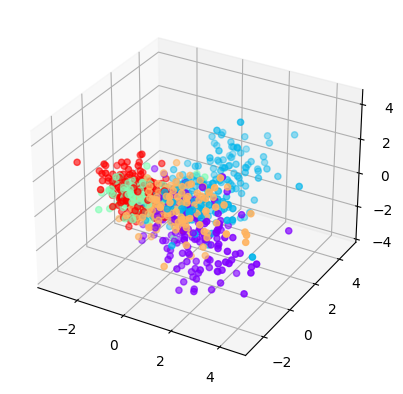

In [30]:
# Convert features to numpy array for PCA
features_np = features.numpy()

# Use PCA to reduce dimensions
pca = PCA(n_components=3)  # Reducing to 3 dimensions for visualization

# Apply PCA
reduced_features = pca.fit_transform(reshaped_features)

# At this point, reduced_features will have shape [num_samples, 3]

# To visualize the 3D results
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=labels, cmap='rainbow')
plt.show()

## Visualize how many PCAS would capture the most variance

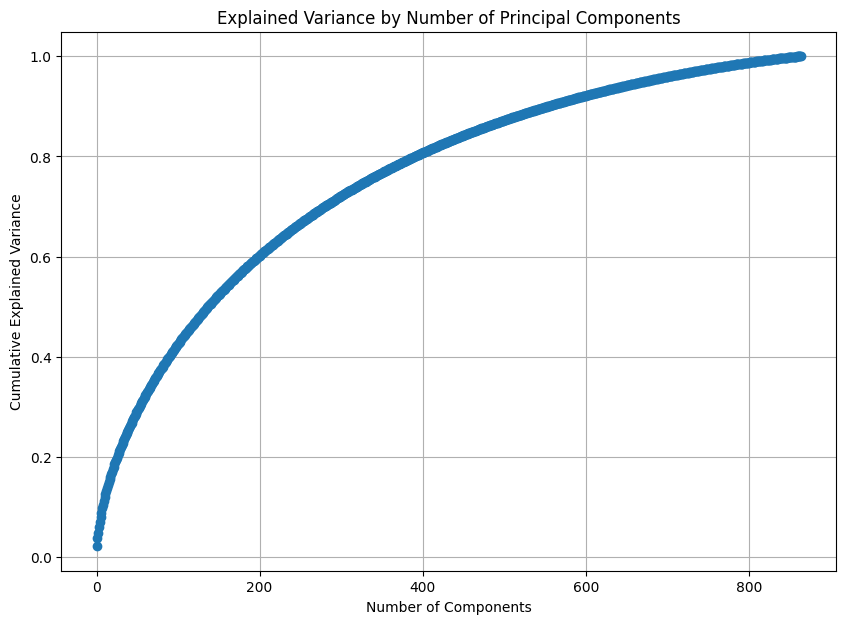

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming reshaped_features is already computed as before
pca = PCA().fit(reshaped_features)

# Calculate explained variances
explained_variances = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(explained_variances, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)
plt.show()

## Graph multiple epochs as time goes on
I chose epoch 0, 4, and 9 to visualize how the plots would change.

Epoch 0/9, Loss: 0.3963


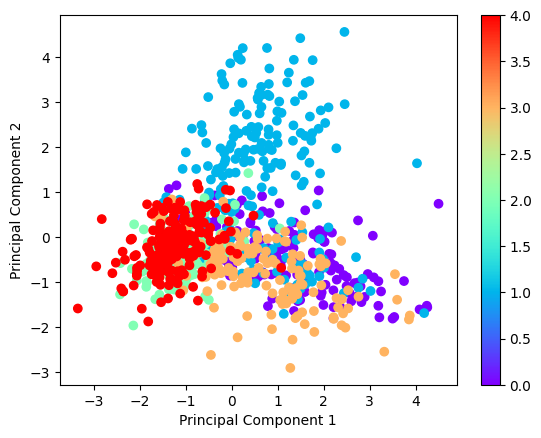

Epoch 1/9, Loss: 0.3700
Epoch 2/9, Loss: 0.3709
Epoch 3/9, Loss: 0.3553
Epoch 4/9, Loss: 0.3442


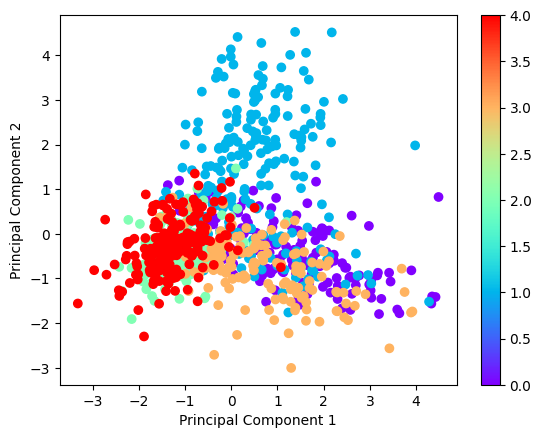

Epoch 5/9, Loss: 0.3261
Epoch 6/9, Loss: 0.3193
Epoch 7/9, Loss: 0.3407
Epoch 8/9, Loss: 0.3328
Epoch 9/9, Loss: 0.3432


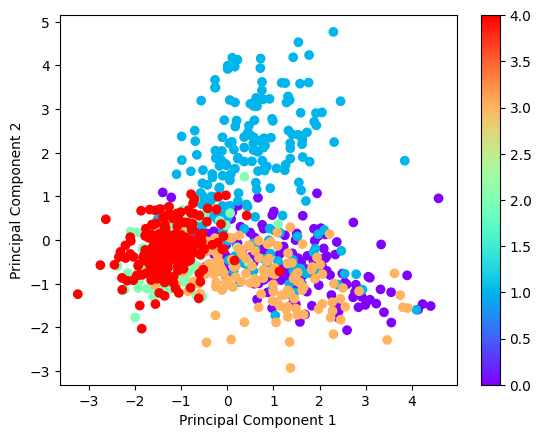

Training complete!


In [74]:
num_epochs = 10  # adjust as needed

def get_features_from_model(model, dataloader, layer_name):
    features_list = []
    labels_list = []

    # Switch model to evaluation mode
    model.eval()

    # Define a hook to get the activations from the desired layer
    def hook(module, input, output):
        features_list.append(output)

    hook_ref = dict()
    for name, layer in model.named_modules():
        if name == layer_name:
            hook_ref[name] = layer.register_forward_hook(hook)

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            labels_list.append(labels)

    for hr in hook_ref.values():
        hr.remove()

    features = torch.cat(features_list, 0)
    labels = torch.cat(labels_list, 0)
    return features, labels

for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}")

    if epoch in (0,4,9):
        layer_name = "layer4.2.conv3"
        features, labels = get_features_from_model(model, test_loader, layer_name)  # Replace 'layer_name' with the name or path of the desired layer in your model
        # Convert features to numpy array for PCA
        features_np = features.numpy()

        # Use PCA to reduce dimensions
        pca = PCA(n_components=2)  # Reducing to 2 dimensions for visualization

        # Reshape the features to be 2D
        reshaped_features = features_np.reshape(features_np.shape[0], -1)

        # Now apply PCA
        reduced_features = pca.fit_transform(reshaped_features)

        # # Visualize the reduced data
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='rainbow')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.colorbar()
        plt.show()


print("Training complete!")

## Plot error loss as a function of epochs

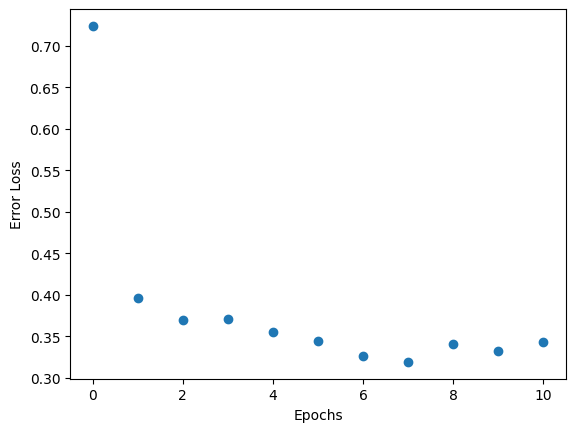

In [9]:
error_loss = [0.7238, 0.3963, 0.3700, 0.3709, 0.3553, 0.3442, 0.3261, 0.3193, 0.3407, 0.3328, 0.3432]
x = [i for i in range(len(error_loss))]
plt.scatter(x, error_loss)
plt.xlabel('Epochs')
plt.ylabel('Error Loss')
plt.show()

## Get test accuracy

In [ ]:
correct = 0
total = 0

with torch.no_grad():  # Deactivates autograd, reducing memory usage and speeding up computations
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the predicted classes

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the test dataset: {100 * correct / total:.2f}%")
